**THIS NOTEBOOK CONTAINS FORECAST OF TRANSACTION AMOUNT FOR SELLER 16 FROM INVOICE DATA WITH TRAIN TEST APPROACH TO FIND THE BEST MODEL BY COMPARING AIC VALUES.**

In [1]:
#Importing the prerequisite libraries that are to be used further.
import pandas as pd
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib.pyplot as plt

**Below is the importing of data file. It also includes changing the format of date time and extracting the date from it.**

In [2]:
invoice=pd.read_csv("inv_transdt_transamt_selrid.csv")

**No null values are there in the code.**

In [3]:
invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86319 entries, 0 to 86318
Data columns (total 3 columns):
TransactionDate    86319 non-null object
SellerId           86319 non-null int64
Trans_amount       86319 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.0+ MB


**Formating the datetime format.**

In [4]:
invoice["TransactionDate"]=pd.to_datetime(pd.to_datetime(invoice["TransactionDate"]).dt.date)

In [5]:
invoice.head()

,TransactionDate,SellerId,Trans_amount
0,2019-03-15,19,10000
1,2017-04-18,19,5000000
2,2019-07-18,1,5000
3,2019-07-18,1,13000
4,2019-07-18,1,17500


In [6]:
seller_count=invoice.groupby("SellerId").count()

In [7]:
seller_count

,TransactionDate,Trans_amount
SellerId,,
1,8,8
2,631,631
3,97,97
5,1790,1790
6,32,32
9,2898,2898
10,20803,20803
11,4118,4118
12,7946,7946


**FORECAST FOR SELLER_16**

**Following is the time series preparation for seller 16 by extracting transaction date and Transaction amount.**

In [8]:
sel=invoice[invoice.SellerId==16][["TransactionDate","Trans_amount"]]
sel=sel.set_index("TransactionDate")
sel = sel.groupby(pd.Grouper(freq="M")).sum()
sel["Trans_amount"]=sel.Trans_amount.apply(lambda x:int(x))
ts=sel["Trans_amount"]

In [9]:
len(ts)

43

**Sample of the series.**

In [10]:
ts.tail(10)

TransactionDate
2018-10-31    163868099
2018-11-30     47445406
2018-12-31      5686118
2019-01-31     10564920
2019-02-28     22966061
2019-03-31     25189560
2019-04-30     10193466
2019-05-31      6002600
2019-06-30     11027357
2019-07-31     10117187
Freq: M, Name: Trans_amount, dtype: int64

In [11]:
ts.tail()

TransactionDate
2019-03-31    25189560
2019-04-30    10193466
2019-05-31     6002600
2019-06-30    11027357
2019-07-31    10117187
Freq: M, Name: Trans_amount, dtype: int64

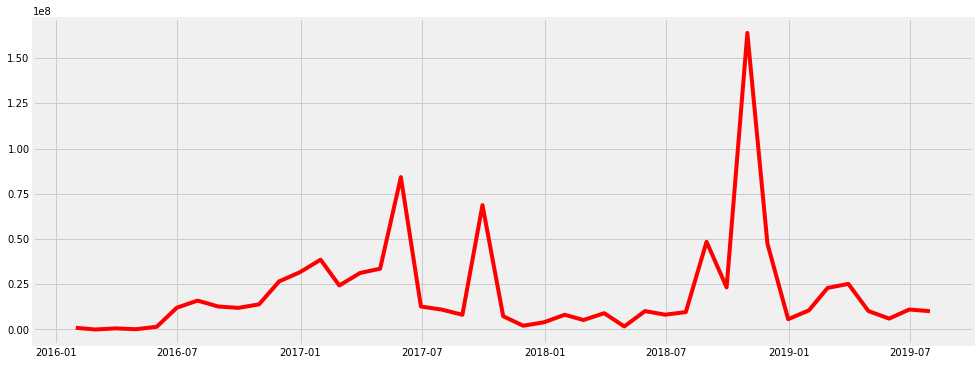

In [12]:
plt.figure(figsize=(15,6))
plt.plot(ts, color="red")

**This is dickey fuller test.**

In [13]:
from statsmodels.tsa.stattools import adfuller
def dft(ts):
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test_stats','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return(dfoutput)

In [14]:
dft(ts)

Test_stats                     -5.077895
p-value                         0.000016
#Lags Used                      0.000000
Number of Observations Used    42.000000
Critical Value (1%)            -3.596636
Critical Value (5%)            -2.933297
Critical Value (10%)           -2.604991
dtype: float64

**This is the sample 10 datapoints.**

In [15]:
ts.head(10)

TransactionDate
2016-01-31      932391
2016-02-29           0
2016-03-31      600153
2016-04-30      144000
2016-05-31     1485450
2016-06-30    12019163
2016-07-31    15960414
2016-08-31    12692813
2016-09-30    11936431
2016-10-31    13885337
Freq: M, Name: Trans_amount, dtype: int64

**Below is the test for stationarity of the time series.**

In [16]:
from statsmodels.tsa.stattools import adfuller
def dft(ts):
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test_stats','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return(dfoutput)

**Testing the stationariy for the series by using Dickey Fuller test.**

In [17]:
dft(ts)

Test_stats                     -5.077895
p-value                         0.000016
#Lags Used                      0.000000
Number of Observations Used    42.000000
Critical Value (1%)            -3.596636
Critical Value (5%)            -2.933297
Critical Value (10%)           -2.604991
dtype: float64

**Clearly the Test_stats is already lesser than the minimum critical values. So with 99% confidence it can be inferred that the series is stationary.**

**Below is the preparation of input parameters for the ARIMA model to be applied on the series.**

In [18]:
from statsmodels.tsa.stattools import acf, pacf
# Requisite libraries for computing auto correlation function and partial auto correlation function. 

In [19]:
lag_acf = acf(ts, nlags=5)
lag_pacf = pacf(ts, nlags=5, method='ols')
#ols stands for ordinary least squared.

Text(0.5, 1.0, 'Autocorrelation Function')

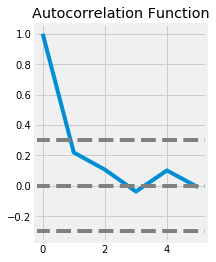

In [20]:
#This is the plotting of acf.
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
            

**From above plot it can be seen that plot is interesecting the upper confidence intervel at lag=4. so value of q is 4.**

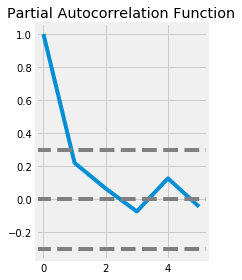

In [21]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

**From above plot it can be seen that plot is interesecting the upper confidence intervel at lag=2. so value of p is 2.**

<font color="blue">**Applying train test approach to the data for seller 16**</font>

**Initially 90 % of data is taken in the training data set and remaining 10% in the testing data set.**

In [22]:
train_size = int(np.ceil(len(ts)*0.9))

In [23]:
#Below is size of training data.
train_size

39

**The data is being split into training and testing set.**

In [24]:
train, test = ts[0:train_size], ts[train_size:len(ts)]

In [25]:
ts.tail()

TransactionDate
2019-03-31    25189560
2019-04-30    10193466
2019-05-31     6002600
2019-06-30    11027357
2019-07-31    10117187
Freq: M, Name: Trans_amount, dtype: int64

In [26]:
train.tail()

TransactionDate
2018-11-30    47445406
2018-12-31     5686118
2019-01-31    10564920
2019-02-28    22966061
2019-03-31    25189560
Freq: M, Name: Trans_amount, dtype: int64

In [27]:
test.head()

TransactionDate
2019-04-30    10193466
2019-05-31     6002600
2019-06-30    11027357
2019-07-31    10117187
Freq: M, Name: Trans_amount, dtype: int64

**Now testing the stationarity of the series.**

In [28]:
dft(train)

Test_stats                     -4.875513
p-value                         0.000039
#Lags Used                      0.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64

**Clearly the test_stats is lesser than even 1% critical value. So the series is stationary.**

In [29]:
#Importing the requisite libraries for arima model.
from statsmodels.tsa.arima_model import ARIMA

**Training the model with calculated values of p,q and d.**

In [30]:
model = ARIMA(train, order=(1, 0,1))
model_fit = model.fit()

**Final prediction on test set of data by model.**

In [31]:
train.index

DatetimeIndex(['2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31'],
              dtype='datetime64[ns]', name='TransactionDate', freq='M')

In [32]:
test.index

DatetimeIndex(['2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31'], dtype='datetime64[ns]', name='TransactionDate', freq='M')

In [33]:
predicted= model_fit.predict(test.index[0], test.index[-1])

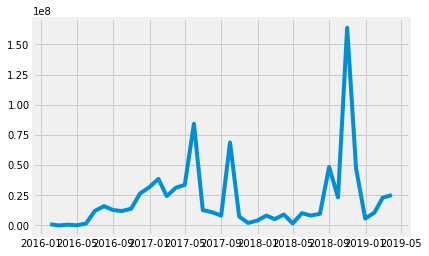

In [34]:
plt.plot(train)

In [35]:
def pred_fin(predicted, train):
    c=pd.Index(predicted.index)
    c=c.insert(0, pd.to_datetime(train.index[-1]))
    lis=list(predicted.values)
    lis.insert(0,train[-1])
    lis=pd.Series(lis,index=c)
    prediction_final=lis.apply(lambda x:int(x))
    return prediction_final

In [36]:
final_prediction=pred_fin(predicted, train)

In [37]:
train.tail()

TransactionDate
2018-11-30    47445406
2018-12-31     5686118
2019-01-31    10564920
2019-02-28    22966061
2019-03-31    25189560
Freq: M, Name: Trans_amount, dtype: int64

In [38]:
final_prediction

2019-03-31    25189560
2019-04-30    22496001
2019-05-31    22114994
2019-06-30    21967208
2019-07-31    21909884
Freq: M, dtype: int64

**test_prediction is the data frame containing the test data and the predicted output by the model.**

<font color="blue">**Akaike information criterion(AIC)**</font>  
**Akaike information criterion is the a model evaluation measure which considers mean sum squared of residuals and the number of parameters to evaluate the quality of a model. So lower the value of aic better is the model.**

In [39]:
model_fit.aic

1458.6069274483575

In [40]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Trans_amount   No. Observations:                   39
Model:                     ARMA(1, 1)   Log Likelihood                -725.303
Method:                       css-mle   S.D. of innovations       28859949.359
Date:                Thu, 01 Aug 2019   AIC                           1458.607
Time:                        11:25:24   BIC                           1465.261
Sample:                    01-31-2016   HQIC                          1460.994
                         - 03-31-2019                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.187e+07   6.09e+06      3.593      0.001    9.94e+06    3.38e+07
ar.L1.Trans_amount     0.3879      0.589      0.658      0.515      -0.767       1.543
ma.L1.Trans_amount    -0.1862      0.623     -0.299      0.767      -1.407       1.034
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5781           +0.0000j            2.5781            0.0000
MA.1            5.3715           +0.0000j            5.3715            0.0000
-----------------------------------------------------------------------------
"""

*For this model aic value is 1437.*

**Below is the forecast of payment amount for seller 16 with 90 percent data in the train set. In the figure below blue line is the training data, red is the forecasted one and green one is the test set value.**

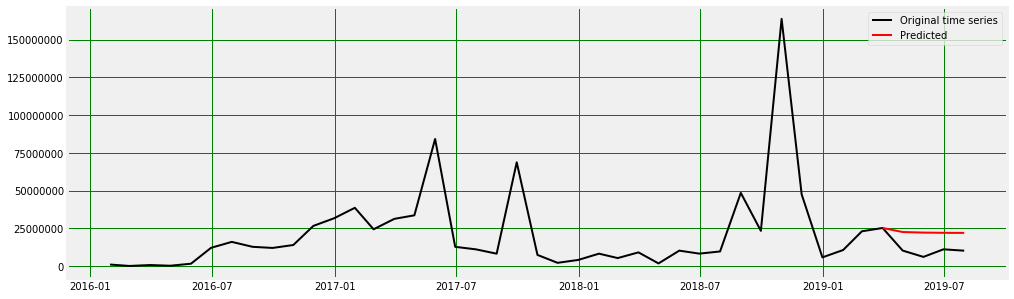

In [41]:
plt.figure(figsize=(15,5))
plt.plot(ts, color="black", linewidth=2, label="Original time series")
plt.plot(final_prediction,color="red", linewidth=2, label="Predicted")
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.grid(True, color="green")
plt.legend(loc="best")
plt.show()

**It is possible that at a different train test ratio we can have a lower value of Akaike Information Constant(aic) i.e. a better model.  
So in the below code an aic is explorated against the train test ratio.**

In [42]:
from statsmodels.tsa.arima_model import ARIMA
#An empty list to store mean squared error.
rmse=[]
#An empty list to store aic.
aic=[]
# An empty list storing fraction of total data present in training set.
ratio=[]
for x in np.arange(0.6,0.95,0.005):
    #size of training set.
    train_size = int(len(ts)*x)
    #splitting the data.    
    train, test = ts[0:train_size], ts[train_size:len(ts)]
    if dft(train)[0]<dft(train)[4]:
        model = ARIMA(train, order=(2,0,1))
        model_fit = model.fit()
        prediction_final= model_fit.predict(test.index[0], test.index[-1])
        aic.append(model_fit.aic)
        rmse.append(np.sqrt(np.mean((-test+prediction_final)**2)))
        ratio.append(x)     

**In above code the if criteria compares the test_stats and the 1% critical value. If it is satisfying the criteria then only further evaluation is done. The corresponding aic values for different models have been stored in aic list.**

<font color="blue">**we will use to criterion to compare the models.**</font>  
**1. ROOT MEAN SQUARED ERROR(rmse)**  
**2. AKAIKI INFORMATION CONSTANT(aic).**

In [43]:
aic_ratio=pd.DataFrame()
aic_ratio["aic"]=aic
aic_ratio["ratio"]=ratio

**Above dataframe contains different aic values corresponding to the fraction of total data in the training set.**

In [44]:
aic_ratio

,aic,ratio
0,1311.845615,0.815
1,1311.845615,0.820
2,1311.845615,0.825
3,1311.845615,0.830
4,1311.845615,0.835
5,1350.242626,0.840
6,1350.242626,0.845
7,1350.242626,0.850
8,1350.242626,0.855
9,1350.242626,0.860


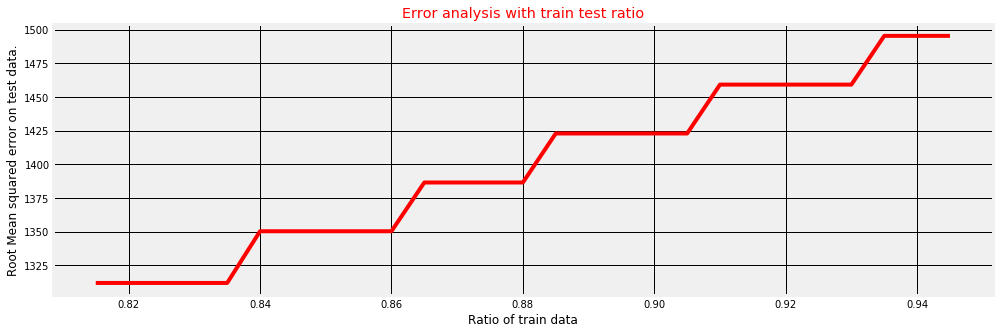

In [45]:
plt.figure(figsize=(15,5))
plt.plot(ratio,aic, color="red")
#plt.plot(ratio,rmse,color="red")
plt.xlabel("Ratio of train data")
plt.ylabel("Root Mean squared error on test data.")
plt.title("Error analysis with train test ratio", color="red")
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.grid(True, color="black")
plt.show() 

<font color="red">**In the above model the value of train size is passed in between 0.6 to 0.95. But in the plot we have only data from 0.775 to 0.950. The reason behind this is from 0.6 to 0.775 all the data have failed the stationarity test by Dicky Fuller test and hence they are automatically rejected.**</font>

**From above plot we can see that as the fraction is increasing aic value is also increasing. So at fraction = 0.815 aic is minimum.**

<font color="blue"> **NOW BELOW CODE IS PERFORMING THE BEST MODEL WITH TRAINING RATION 0.815**

In [46]:
train_size = int(np.ceil(len(ts)*0.81))

In [47]:
train_size

35

In [48]:
train, test = ts[0:train_size], ts[train_size:len(ts)]

In [49]:
dft(train)

Test_stats                     -4.487809
p-value                         0.000207
#Lags Used                      0.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64

In [50]:
from statsmodels.tsa.arima_model import ARIMA

**Below is preparing the final arima model.**

In [51]:
model = ARIMA(train, order=(2,0,1))
model_fit = model.fit()

In [52]:
train.tail()

TransactionDate
2018-07-31      9605840
2018-08-31     48458100
2018-09-30     23272416
2018-10-31    163868099
2018-11-30     47445406
Freq: M, Name: Trans_amount, dtype: int64

**Prediction is done for test set as well as for coming 6 months.**

In [53]:
predicted= model_fit.predict("2018-11-30", "2019-12-31")

In [54]:
prediction_final=pred_fin(predicted, train)

In [55]:
model_fit.aic

1311.8456148066346

In [56]:
model_fit.bic

1319.6223551140815

**Above is the aic value for the model. which is least of all the possible models.**

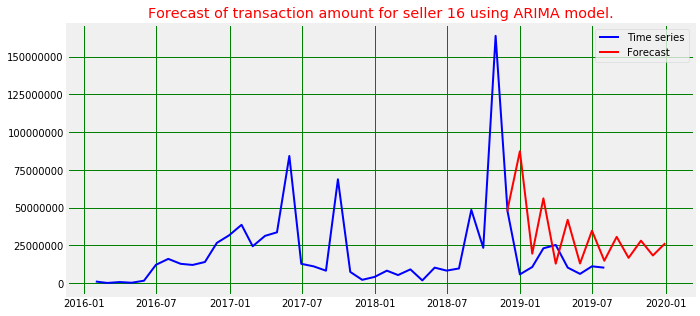

In [57]:
plt.figure(figsize=(10,5))
plt.plot(ts, color="blue", linewidth=2, label="Time series")
plt.plot(prediction_final,color="red", linewidth=2, label="Forecast")
plt.title("Forecast of transaction amount for seller 16 using ARIMA model.", color="red")
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.grid(True, color="green")
plt.legend(loc="best")
plt.show()